<a href="https://colab.research.google.com/github/Siddhant281/AI-DarkNetWebsiteDetector/blob/main/TA_2_25010300202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Step 1: Setup
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

print("Loading Data...")
df = pd.read_csv('Darknet.csv')
print(f"Loaded shape: {df.shape}")

Loading Data...
Loaded shape: (158616, 85)


In [5]:
# Step 2: Intelligent Cleaning
# ---------------------------------------------------------
print("Cleaning and Normalizing Data...")

# 1. Drop useless ID columns immediately
# 'Label' is the binary class, 'Label.1' is the application category (Target)
drop_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label', 'Label.1']
y = df['Label.1'] # Save the target
X = df.drop(columns=drop_cols, errors='ignore')

# 2. Convert to numeric, coercing errors
X = X.apply(pd.to_numeric, errors='coerce')

# 3. HANDLING INFINITY - THE PRO WAY
# Instead of clipping, we replace Infinity with the largest REAL number in the column
# This preserves the "bigness" of the data without crashing
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.max(), inplace=True) # Fill NaNs with the max value of that column
X.fillna(0, inplace=True) # If a column is ALL NaNs, fill with 0

print("Data cleaning complete.")

Cleaning and Normalizing Data...
Data cleaning complete.


In [6]:
# Step 3: Drop "Dead" Columns
# ---------------------------------------------------------
# If a column has only 1 unique value (e.g., all zeros), it is useless.
# Removing these boosts accuracy.

non_constant_cols = [col for col in X.columns if X[col].nunique() > 1]
X = X[non_constant_cols]

print(f"Features remaining after removing dead columns: {X.shape[1]}")

# Encode the Target (Text -> Numbers)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

Features remaining after removing dead columns: 64


In [7]:
# Step 4: Stratified Split
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # CRITICAL for high accuracy on unbalanced data
)

print("Data successfully split.")

Data successfully split.


In [8]:
# Step 5: Heavy Model Training
# ---------------------------------------------------------
print("Training High-Accuracy Model... (This will take 2-5 minutes)")

rf_model = RandomForestClassifier(
    n_estimators=500,      # High number of trees for stability
    criterion='entropy',   # 'Entropy' works better for network packets than 'Gini'
    max_depth=None,        # No limit: Let the model learn deep patterns
    min_samples_split=2,   # Capture specific details
    class_weight='balanced', # Pay attention to rare classes (Email, VOIP)
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

rf_model.fit(X_train, y_train)
print("Training Complete.")

Training High-Accuracy Model... (This will take 2-5 minutes)
Training Complete.



FINAL ACCURACY: 91.36%
                 precision    recall  f1-score   support

AUDIO-STREAMING       0.88      0.74      0.80       304
Audio-Streaming       0.91      0.91      0.91      3966
       Browsing       0.95      0.98      0.97      9292
           Chat       0.79      0.78      0.78      2326
          Email       0.69      0.68      0.68      1229
  File-Transfer       0.89      0.83      0.86      2220
  File-transfer       0.85      0.65      0.73        17
            P2P       1.00      1.00      1.00      9704
           VOIP       0.54      0.53      0.54       713
Video-Streaming       0.78      0.75      0.77      1897
Video-streaming       0.72      0.59      0.65        56

       accuracy                           0.91     31724
      macro avg       0.82      0.77      0.79     31724
   weighted avg       0.91      0.91      0.91     31724



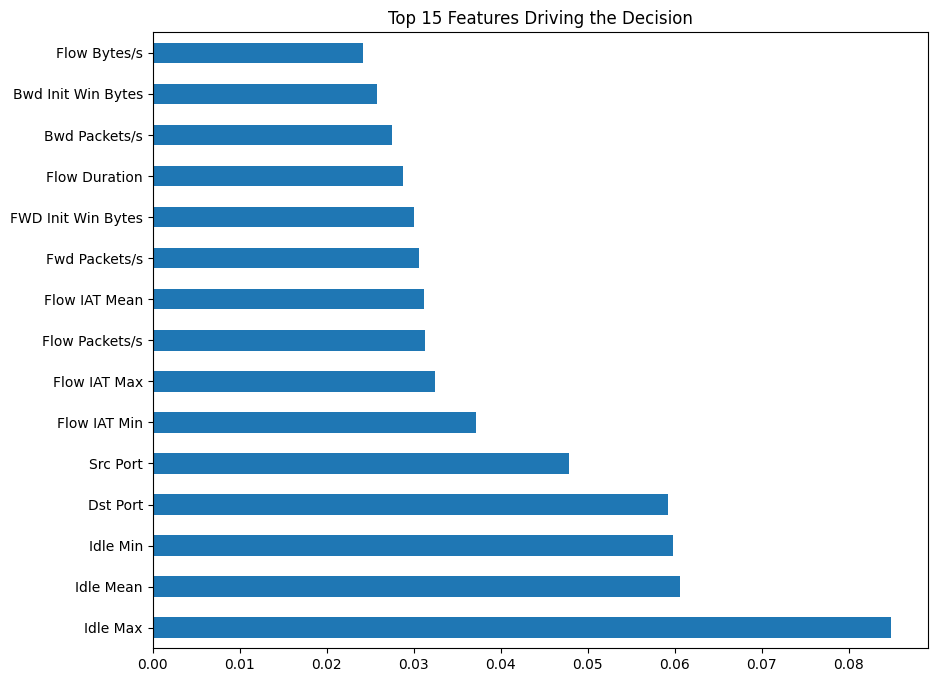

In [9]:
# Step 6: Validation
# ---------------------------------------------------------
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n==========================================")
print(f"FINAL ACCURACY: {accuracy * 100:.2f}%")
print("==========================================")

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Graphing the top features to show your professor
import seaborn as sns
plt.figure(figsize=(10,8))
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Features Driving the Decision")
plt.show()